In [1]:
import numpy as np
import pandas as pd
from pandas import Timestamp

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mse

C:\Users\natha\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's have a look at the dataset

In [2]:
path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
df = pd.read_csv(path)
df.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,01/01/2016 12:00:00 AM,-2.80
1,Oak Street Weather Station,01/01/2016 12:00:00 AM,-2.30
2,Foster Weather Station,01/01/2016 12:00:00 AM,-3.67
3,63rd Street Weather Station,01/01/2016 01:00:00 AM,-3.40
4,Foster Weather Station,01/01/2016 01:00:00 AM,-4.56


For the basic ARIMA model we can't process the 3 different stations altogether, so we need to separate them into different columns

In [3]:
df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
stations = df['Station Name'].unique()
station_data = {station: df[df['Station Name'] == station].copy() for station in stations}

# Preview first rows for each station
station_data_preview = {station: data.head() for station, data in station_data.items()}
print(station_data_preview)

{'63rd Street Weather Station':                    Station Name Measurement Timestamp  Air Temperature
0   63rd Street Weather Station   2016-01-01 00:00:00             -2.8
3   63rd Street Weather Station   2016-01-01 01:00:00             -3.4
8   63rd Street Weather Station   2016-01-01 02:00:00             -4.2
9   63rd Street Weather Station   2016-01-01 03:00:00             -5.1
14  63rd Street Weather Station   2016-01-01 04:00:00             -5.7, 'Oak Street Weather Station':                   Station Name Measurement Timestamp  Air Temperature
1   Oak Street Weather Station   2016-01-01 00:00:00             -2.3
5   Oak Street Weather Station   2016-01-01 01:00:00             -3.2
7   Oak Street Weather Station   2016-01-01 02:00:00             -4.0
10  Oak Street Weather Station   2016-01-01 03:00:00             -4.8
13  Oak Street Weather Station   2016-01-01 04:00:00             -5.5, 'Foster Weather Station':               Station Name Measurement Timestamp  Air Temperatur

We have to take care of possible missing values.

In [4]:
for station, data in station_data.items():
    data.set_index('Measurement Timestamp', inplace=True)
    data = data.asfreq('H')  # Assuming hourly frequency
    data['Air Temperature'].fillna(method='ffill', inplace=True)  # Forward fill missing values
    station_data[station] = data

Let's plot the time series for each station to visualize the data

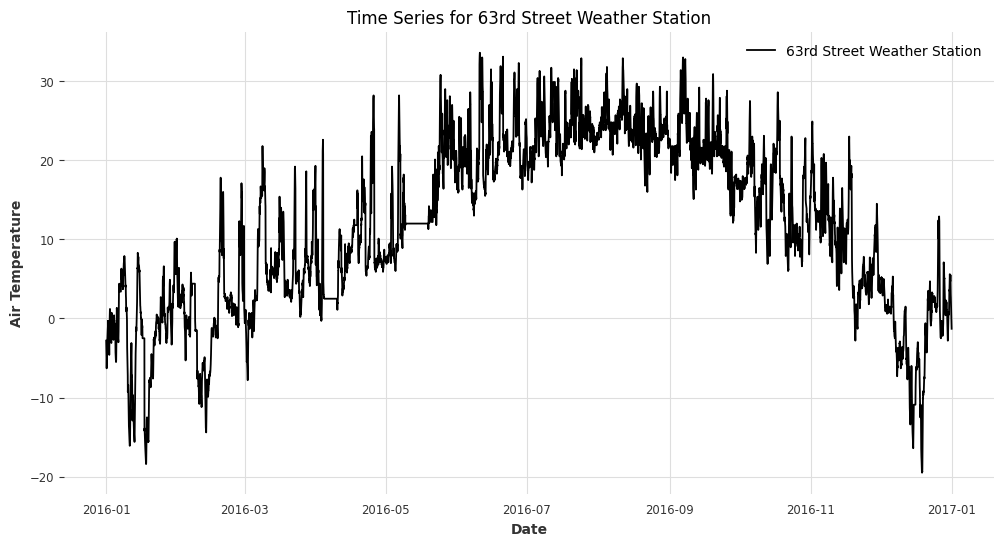

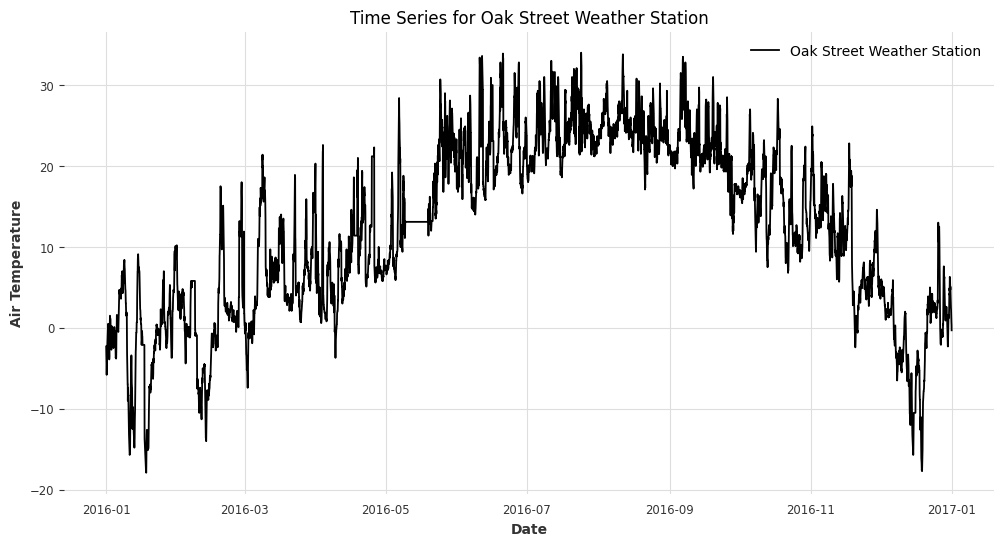

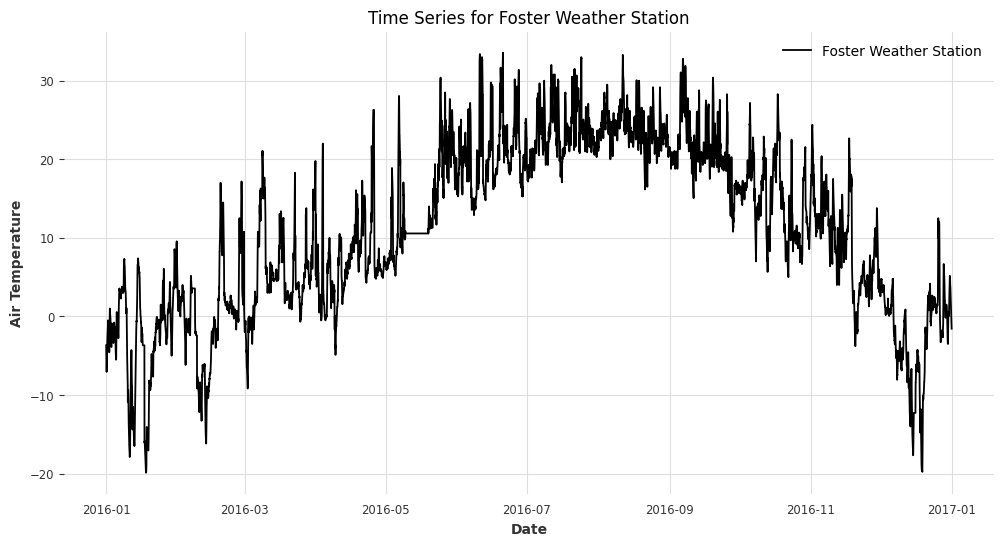

In [5]:
for station, data in station_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Air Temperature'], label=station)
    plt.title(f'Time Series for {station}')
    plt.xlabel('Date')
    plt.ylabel('Air Temperature')
    plt.legend()
    plt.show()

Prepare data for time series modeling

In [7]:
time_series_data = {station: TimeSeries.from_dataframe(data.reset_index(), time_col='Measurement Timestamp', value_cols='Air Temperature')
                    for station, data in station_data.items()}

For each time series, we will now plot the ACF and PACF, along with those of the differenced series, to determine the optimal parameters for the ARIMA model.

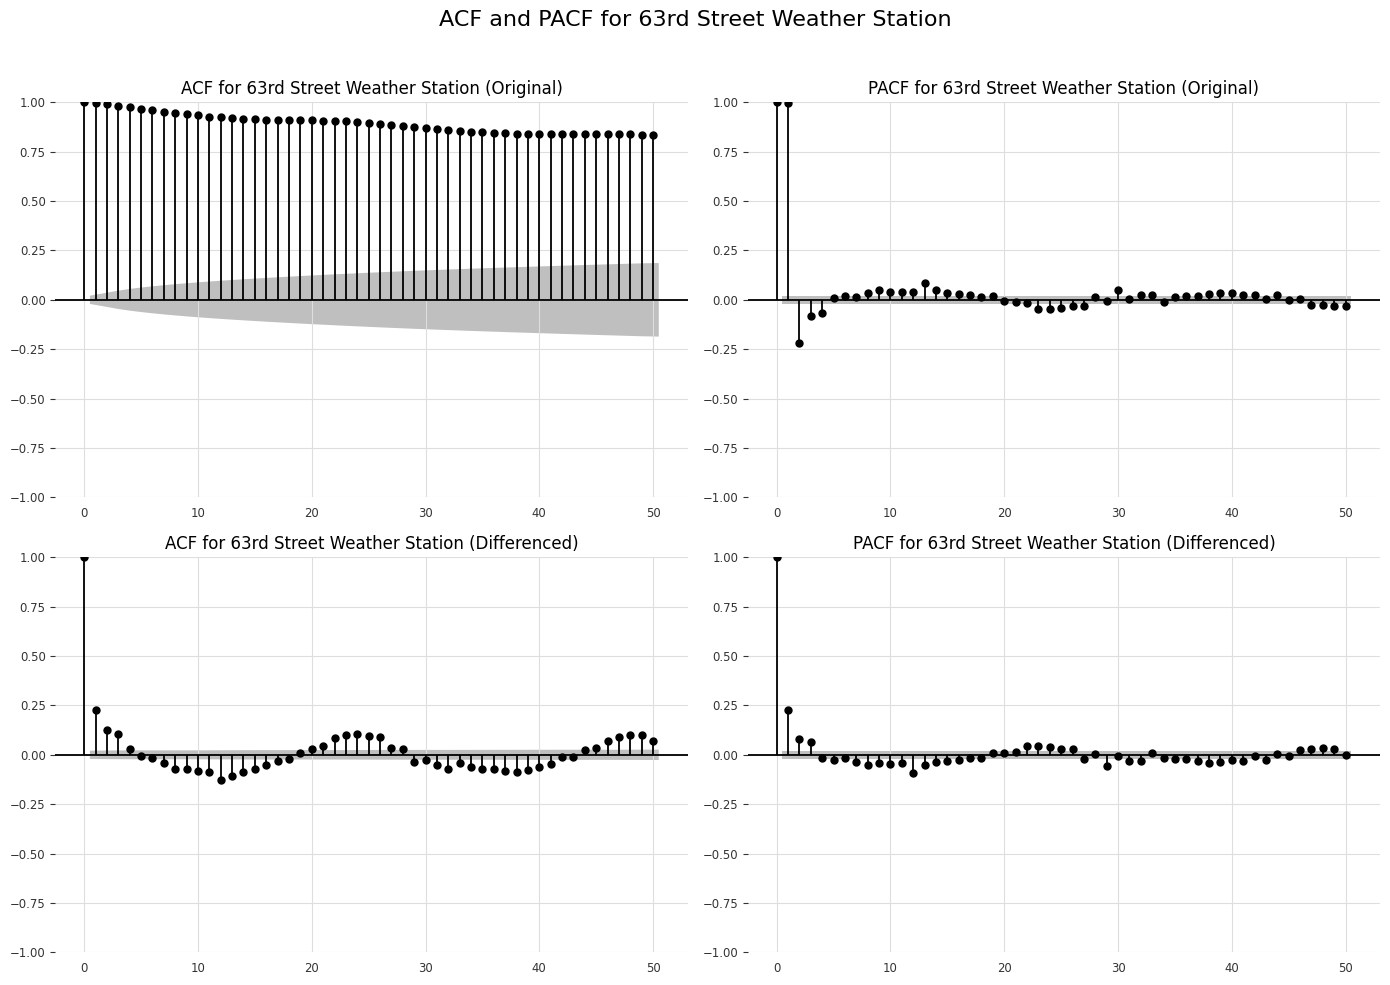

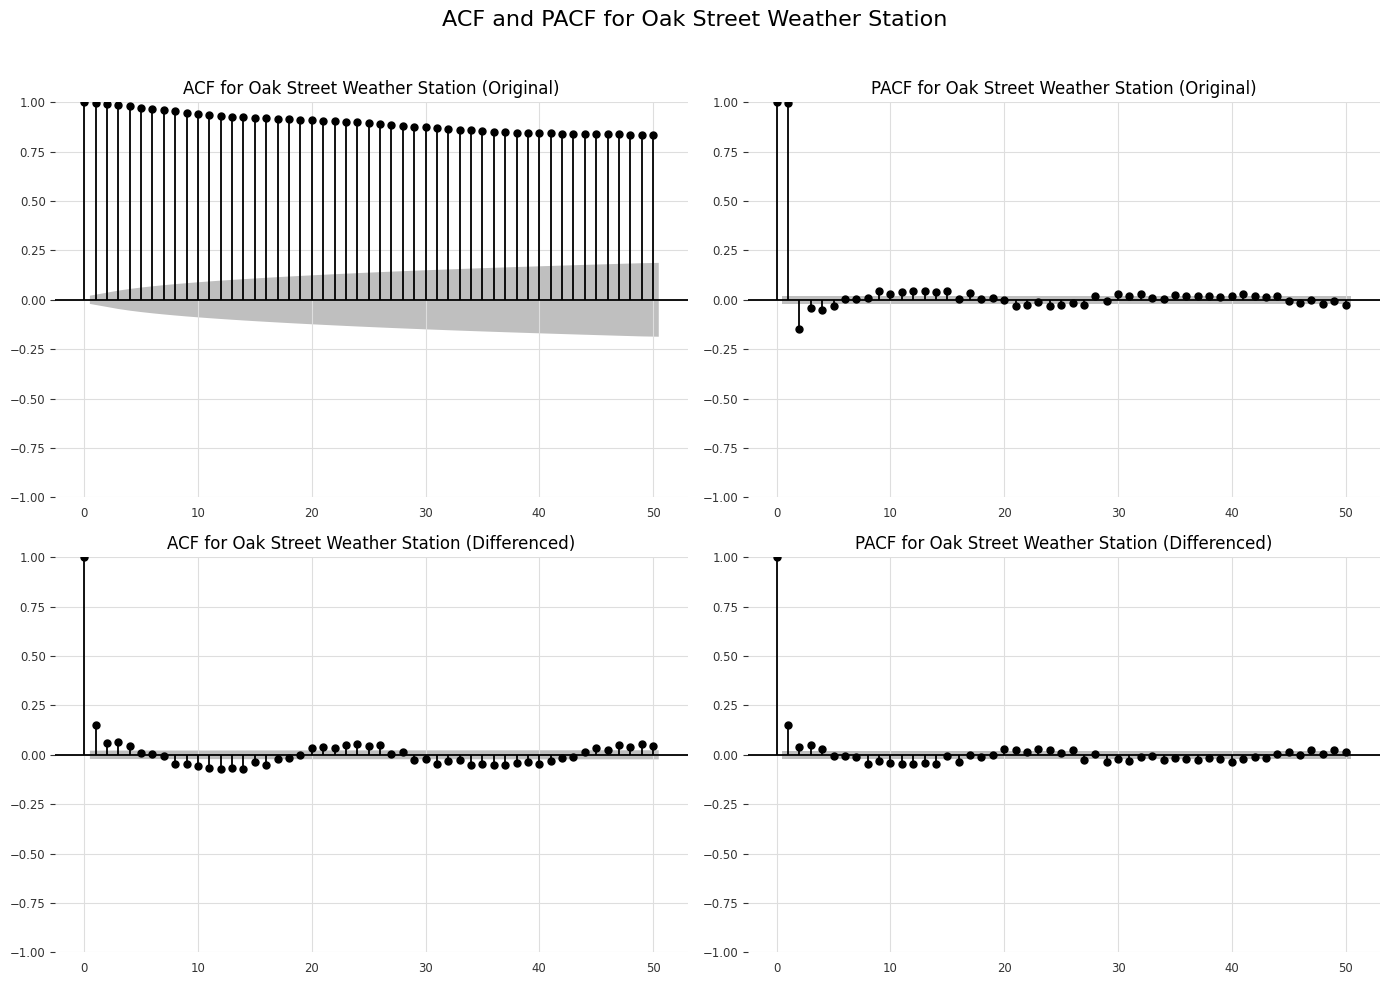

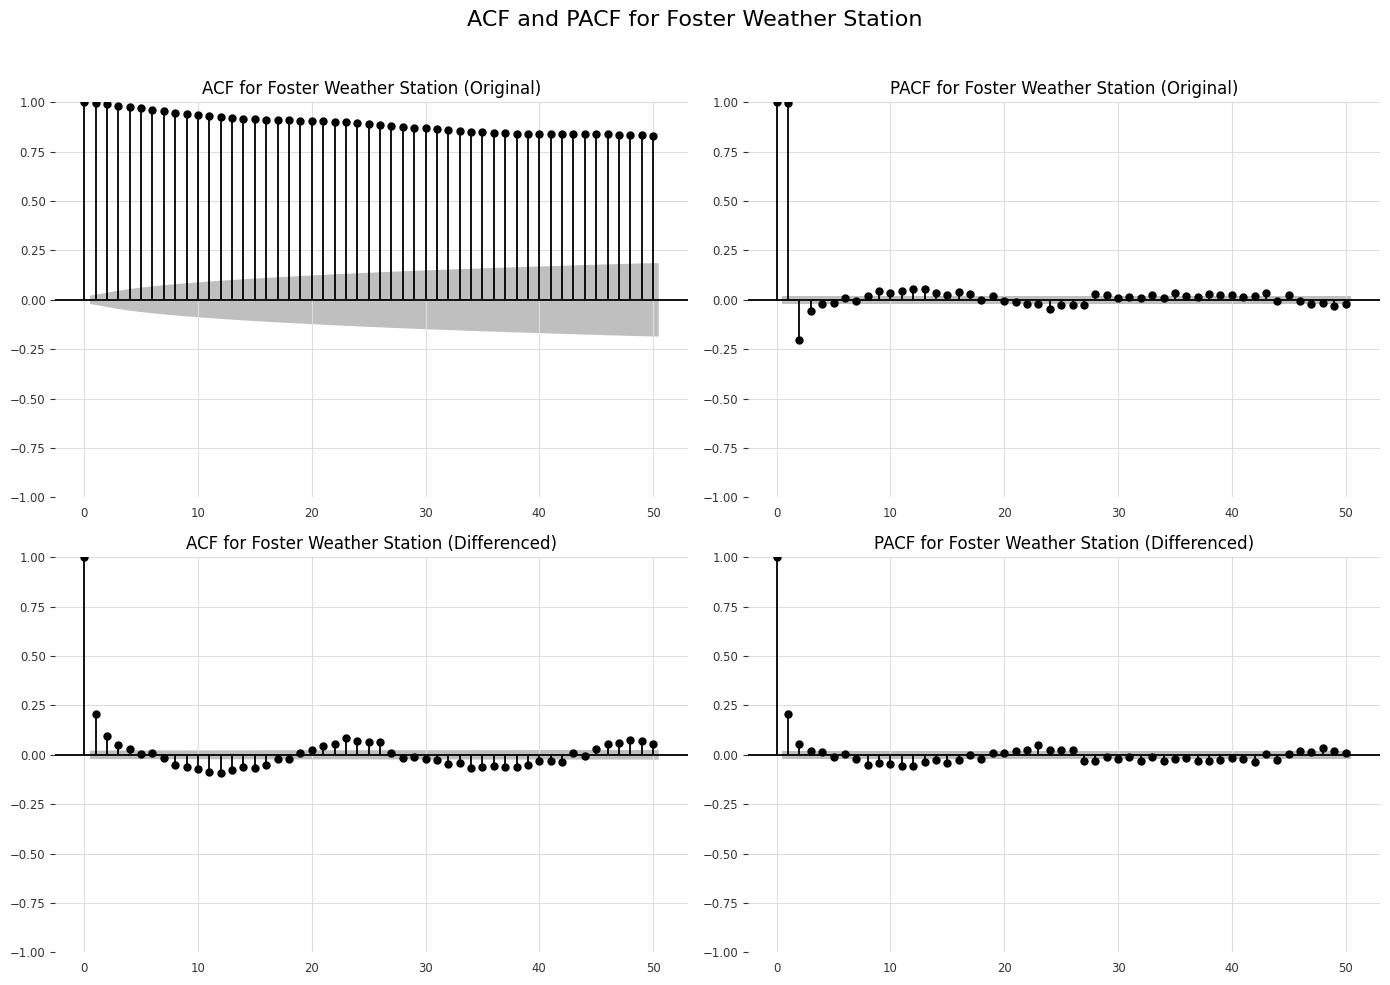

In [8]:
for station, series in time_series_data.items():
    series_pd = series.pd_series()
    
    diff_series_pd = series_pd.diff().dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'ACF and PACF for {station}', fontsize=16)
    
    # ACF and PACF for original series
    plot_acf(series_pd, lags=50, ax=axes[0, 0])
    axes[0, 0].set_title(f'ACF for {station} (Original)')
    
    plot_pacf(series_pd, lags=50, ax=axes[0, 1])
    axes[0, 1].set_title(f'PACF for {station} (Original)')
    
    # ACF and PACF for differenced series
    plot_acf(diff_series_pd, lags=50, ax=axes[1, 0])
    axes[1, 0].set_title(f'ACF for {station} (Differenced)')
    
    plot_pacf(diff_series_pd, lags=50, ax=axes[1, 1])
    axes[1, 1].set_title(f'PACF for {station} (Differenced)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

We observe that one suitable set of hyperparameters for this problem can be (p=1,d=1,q=1)

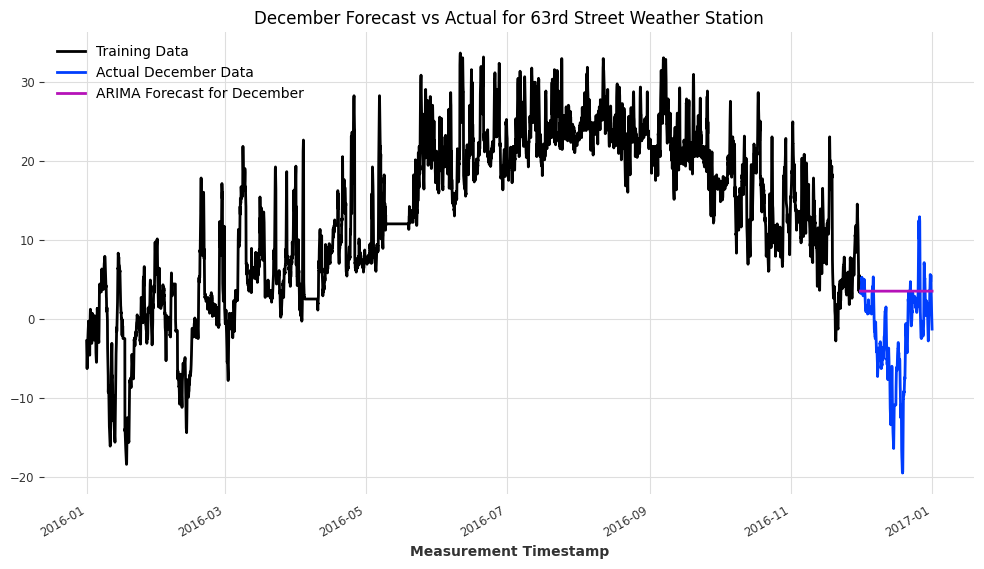

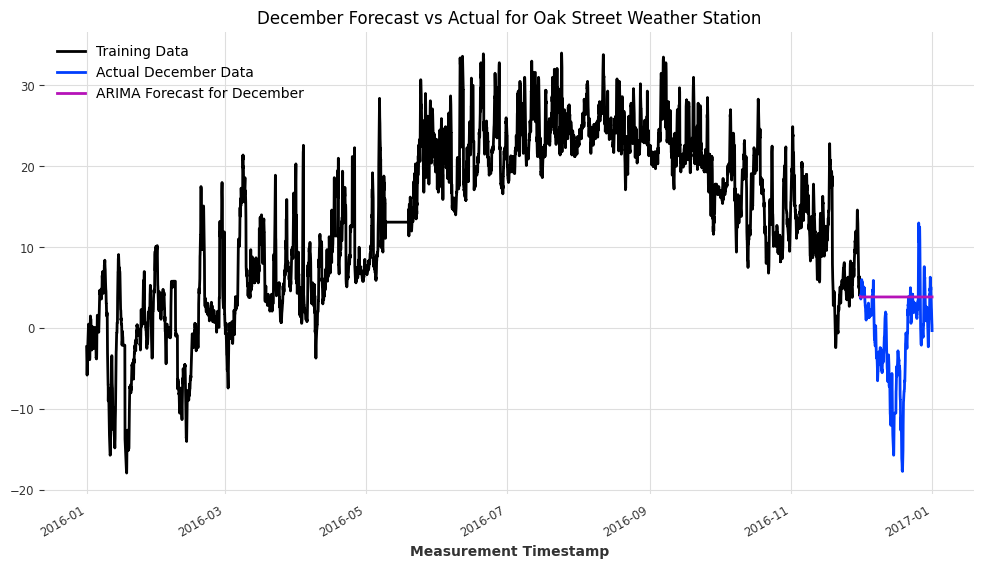

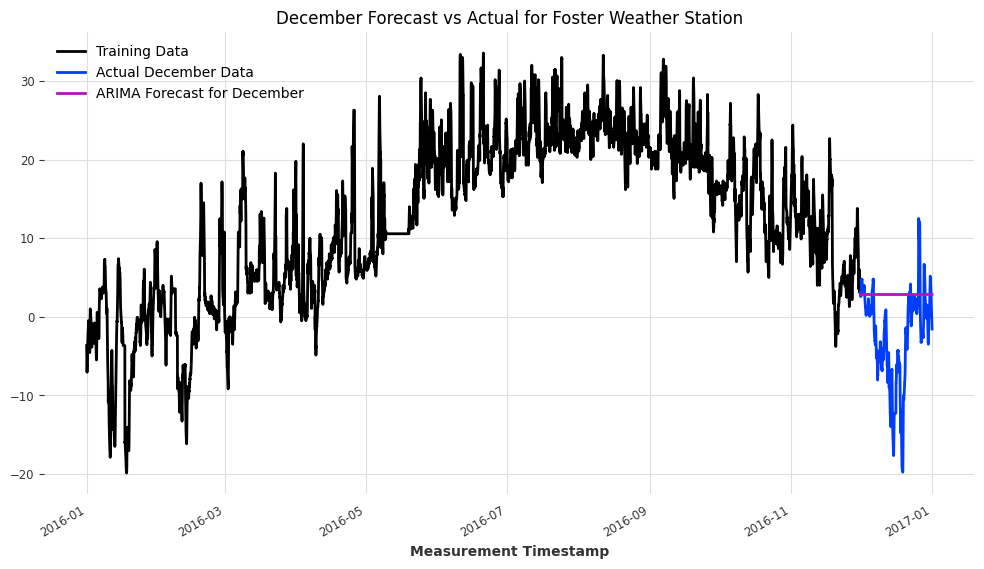


Mean Squared Error for each station:
63rd Street Weather Station: 62.475330171704286
Oak Street Weather Station: 57.96803278816701
Foster Weather Station: 64.11034484255829


In [13]:
train_series_data = {}
validation_series_data = {}
forecasts = {}
mse_scores = {}

for station, series in time_series_data.items():
    # Split the series into training (up to Nov 30) and validation (December)
    train_series, validation_series = series.split_before(Timestamp("2016-12-01"))
    train_series_data[station] = train_series
    validation_series_data[station] = validation_series

    model = ARIMA(1, 1, 1)
    model.fit(train_series)
    forecast = model.predict(len(validation_series))

    forecasts[station] = forecast
    mse_value = mse(validation_series, forecast)
    mse_scores[station] = mse_value

    plt.figure(figsize=(12, 6))
    train_series.plot(label='Training Data')
    validation_series.plot(label='Actual December Data')
    forecast.plot(label='ARIMA Forecast for December')
    plt.title(f'December Forecast vs Actual for {station}')
    plt.legend()
    plt.show()

print("\nMean Squared Error for each station:")
for station, score in mse_scores.items():
    print(f"{station}: {score}")